In [2]:
!nvidia-smi

Sat Jan 16 09:27:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)

2.4.0


In [4]:
# https://github.com/42io/dataset/tree/master/google_speech_commands
DATASET_FILE = '1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu' # 0-9up.npz

In [5]:
!test -f "$DATASET_FILE" || gdown --id "$DATASET_FILE" -O "$DATASET_FILE"

Downloading...
From: https://drive.google.com/uc?id=1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu
To: /content/1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu
2.59GB [00:29, 87.1MB/s]


In [6]:
md5 = !md5sum "$DATASET_FILE"
assert '54821a74684e7bbb9b3acd853960d9cd' == md5[0].split()[0]

In [7]:
dset = np.load(DATASET_FILE)
print(dset['x_train'].shape)

(1095480, 637)


In [8]:
x_train, x_test, x_valid = (
    dset[i].reshape(-1, 49, 13)[:,1:-1]
    for i in ['x_train', 'x_test', 'x_valid']
)
y_train = dset['y_train']
y_test  = dset['y_test']
y_valid = dset['y_valid']

In [9]:
def spectrogram_masking(spectrogram, dim=1, masks_number=2, mask_max_size=5):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [10]:
plt.rc('figure', figsize=(13, 4))

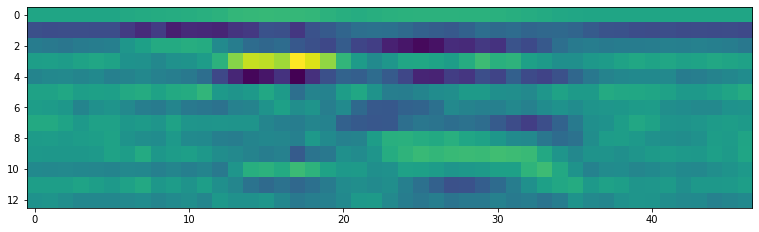

In [11]:
plt.imshow(x_train[0].T)

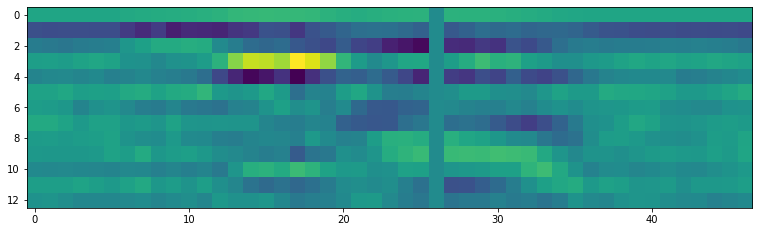

In [12]:
plt.imshow(spectrogram_masking(x_train[0:1], 1, 3, 3).numpy()[0].T)

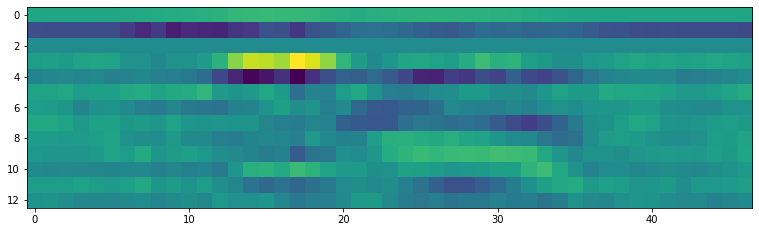

In [13]:
plt.imshow(spectrogram_masking(x_train[0:1], 2, 2, 2).numpy()[0].T)

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(len(x_train))
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.map(lambda x, y: (spectrogram_masking(x, 1, 3, 3), y))
train_dataset = train_dataset.map(lambda x, y: (spectrogram_masking(x, 2, 2, 2), y))

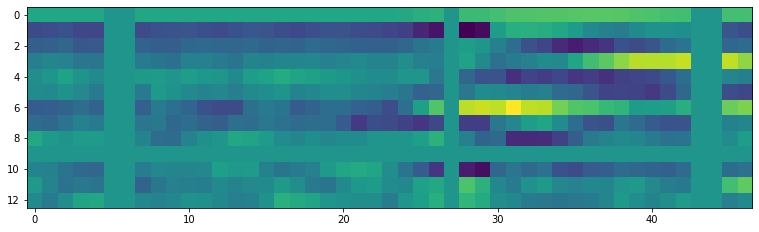

In [15]:
plt.imshow(list(train_dataset.take(1))[0][0][0].numpy().T)

In [16]:
# https://arxiv.org/pdf/2005.06720.pdf

def streaming_input_output(streaming, t, inputs, otputs, x):
  if streaming:
    otputs.append(x)
    x = keras.Input(shape=[t] + x.shape[2:])
    inputs.append(x)
  return x

def build_model(streaming=False):

  # resetting the layer name generation counter
  keras.backend.clear_session()

  inputs  = []
  outputs = []

  x_in = keras.Input(shape=[1, 1, 13] if streaming else [47, 13])
  x = x_in if streaming else keras.backend.expand_dims(x_in, -2)

  x = keras.layers.Conv2D(64, 1, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.SpatialDropout2D(x.shape[-1]/1280.0)(x)

  for i in range(4):
    x = streaming_input_output(streaming, 2, inputs, outputs, x)
    x = keras.layers.SeparableConv2D(x.shape[-1], kernel_size=[2, 1], 
                                     dilation_rate=[1 if streaming else 2**i, 1], 
                                     use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.SpatialDropout2D(x.shape[-1]/1280.0)(x)

  x = streaming_input_output(streaming, 32, inputs, outputs, x)
  x = keras.layers.AveragePooling2D([x.shape[1], 1])(x)
  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(x.shape[-1] // 2, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.Dropout(x.shape[-1]/1280.0)(x)

  x = keras.layers.Dense(12)(x)
  x = keras.layers.Softmax()(x)

  model = keras.Model(inputs=[x_in] + inputs, outputs=[x] + outputs)

  model.summary()

  return model

In [17]:
model = build_model()

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47, 13)]          0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 47, 1, 13)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 1, 64)         832       
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 1, 64)         256       
_________________________________________________________________
re_lu (ReLU)                 (None, 47, 1, 64)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 47, 1, 64)         0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 46, 1, 64)         4224  

In [18]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=100,
        restore_best_weights=True)

history = model.fit(train_dataset,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stopping],
                    verbose=2,
                    epochs=100500)

Epoch 1/100500
8559/8559 - 86s - loss: 0.4151 - accuracy: 0.8682 - val_loss: 0.1073 - val_accuracy: 0.9656
Epoch 2/100500
8559/8559 - 43s - loss: 0.2390 - accuracy: 0.9240 - val_loss: 0.0822 - val_accuracy: 0.9739
Epoch 3/100500
8559/8559 - 43s - loss: 0.2101 - accuracy: 0.9331 - val_loss: 0.0777 - val_accuracy: 0.9768
Epoch 4/100500
8559/8559 - 43s - loss: 0.1973 - accuracy: 0.9371 - val_loss: 0.0778 - val_accuracy: 0.9748
Epoch 5/100500
8559/8559 - 43s - loss: 0.1870 - accuracy: 0.9402 - val_loss: 0.0691 - val_accuracy: 0.9768
Epoch 6/100500
8559/8559 - 43s - loss: 0.1801 - accuracy: 0.9422 - val_loss: 0.0658 - val_accuracy: 0.9798
Epoch 7/100500
8559/8559 - 43s - loss: 0.1741 - accuracy: 0.9442 - val_loss: 0.0677 - val_accuracy: 0.9783
Epoch 8/100500
8559/8559 - 43s - loss: 0.1684 - accuracy: 0.9459 - val_loss: 0.0628 - val_accuracy: 0.9795
Epoch 9/100500
8559/8559 - 43s - loss: 0.1662 - accuracy: 0.9465 - val_loss: 0.0615 - val_accuracy: 0.9807
Epoch 10/100500
8559/8559 - 43s - los

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


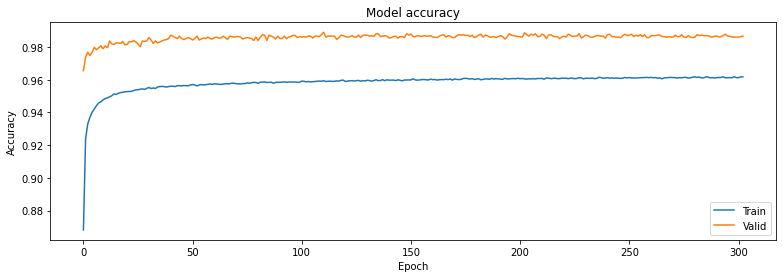

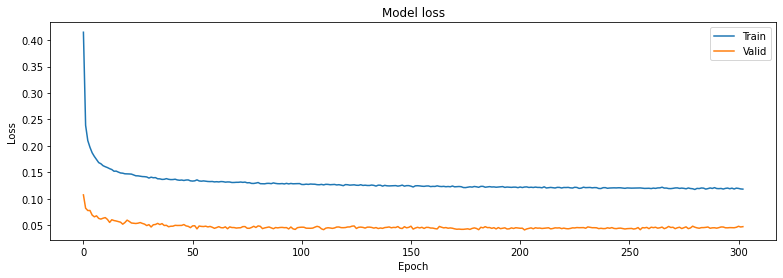

In [19]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [20]:
results = model.evaluate(x_train, y_train, verbose=0)
print('train loss, train acc:', results)

results = model.evaluate(x_test, y_test, verbose=0)
print('test loss, test acc:', results)

results = model.evaluate(x_valid, y_valid, verbose=0)
print('valid loss, valid acc:', results)

train loss, train acc: [0.034716565161943436, 0.9890047907829285]
test loss, test acc: [0.06848850101232529, 0.9777365326881409]
valid loss, valid acc: [0.04104166105389595, 0.9887173175811768]


In [21]:
assert(len(x_test) + len(x_valid) == 7141)
pred = model.predict(x_test).argmax(axis=-1)
print(np.sum(pred != y_test), len(pred))
pred = model.predict(x_valid).argmax(axis=-1)
print(np.sum(pred != y_valid), len(pred))

84 3773
38 3368


In [22]:
stream_model = build_model(True)

# copy weights from old model to new one
for layer in stream_model.layers:
    if layer.get_weights():
      print("Transfer weights for layer {}".format(layer.name))
      layer.set_weights(model.get_layer(name=layer.name).get_weights())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 1, 64)]  0                                            
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 1, 1, 64)     0           input_6[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 64)           0           average_pooling2d[0][0]          
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           2048        flatten[0][0]                    
______________________________________________________________________________________________

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(stream_model)
converter.experimental_new_converter = False
tflite_model = converter.convert()
with open("dcnn.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfcbl3400/assets


In [24]:
%%capture --no-stderr
!apt install xxd
!git clone https://github.com/tensorflow/tensorflow.git -b v2.3.1 --depth 1 tf
!make -C tf/ -f tensorflow/lite/micro/tools/make/Makefile generate_hello_world_make_project
!ln -s tf/tensorflow/lite/micro/tools/make/gen/linux_x86_64/prj/hello_world/make/tensorflow
!ln -s tf/tensorflow/lite/micro/tools/make/gen/linux_x86_64/prj/hello_world/make/third_party

In [25]:
%%file guess.cc
#include <fstream>
#include <list>

#include "tensorflow/lite/micro/all_ops_resolver.h"
#include "tensorflow/lite/micro/micro_error_reporter.h"
#include "tensorflow/lite/micro/micro_interpreter.h"
#include "tensorflow/lite/schema/schema_generated.h"
#include "tensorflow/lite/version.h"

static_assert(sizeof(float) == 4, "WTF");

#define TFLITE_MINIMAL_CHECK(x, ...)                                          \
  if (!(x)) {                                                                 \
    TF_LITE_REPORT_ERROR(error_reporter, __VA_ARGS__);                        \
    TF_LITE_REPORT_ERROR(error_reporter, "Err at %s:%d", __FILE__, __LINE__); \
    exit(1);                                                                  \
  }

//-------------------------------------------------------------------//

namespace {
  char *buffer = nullptr;
  tflite::ErrorReporter* error_reporter = nullptr;
  constexpr size_t kTensorArenaSize = 1000 * 1024;
  alignas(16) uint8_t tensor_arena[kTensorArenaSize];
}

//-------------------------------------------------------------------//

class NonCopyable {
protected:
    NonCopyable(NonCopyable const&) = delete;
    NonCopyable& operator=(NonCopyable const&) = delete;
    NonCopyable() = default;
};

//-------------------------------------------------------------------//

class StreamingState : NonCopyable
{
    char  *i, *o, *r;
    size_t i_sz, o_sz, mv_sz;
    void init(char* ii, size_t is, char* oo, size_t os);
    void (*strategy)(StreamingState* self) = &default_strategy_impl;
    static void default_strategy_impl(StreamingState* self);
    static void dilated_strategy_impl(StreamingState* self);

public:
    StreamingState(TfLiteTensor* ii, TfLiteTensor* oo);
    StreamingState(TfLiteTensor* ii, size_t ss);
    StreamingState(TfLiteTensor* ii, TfLiteTensor* oo, size_t d);
    ~StreamingState() { delete[] r; }
    void stream() { strategy(this); }
};

void StreamingState::init(char* ii, size_t is, char* oo, size_t os)
{
    o = oo, i = ii, i_sz = is, o_sz = os;
    TFLITE_MINIMAL_CHECK(i_sz > o_sz, "WTF");
    memset(i, 0, i_sz);
    r = new char[i_sz]();
    TFLITE_MINIMAL_CHECK(r != nullptr, "WTF");
    mv_sz = i_sz - o_sz; 
}

StreamingState::StreamingState(TfLiteTensor* ii, TfLiteTensor* oo)
{
    TFLITE_MINIMAL_CHECK(oo->type == kTfLiteFloat32, "WTF");
    TFLITE_MINIMAL_CHECK(ii->type == kTfLiteFloat32, "WTF");
    TFLITE_MINIMAL_CHECK(ii->bytes % oo->bytes == 0, "WTF");
    init(ii->data.raw, ii->bytes, oo->data.raw, oo->bytes);
}

StreamingState::StreamingState(TfLiteTensor* ii, TfLiteTensor* oo, size_t d)
{
    TFLITE_MINIMAL_CHECK(oo->type == kTfLiteFloat32, "WTF");
    TFLITE_MINIMAL_CHECK(ii->type == kTfLiteFloat32, "WTF");
    TFLITE_MINIMAL_CHECK(ii->bytes % oo->bytes == 0, "WTF");
    TFLITE_MINIMAL_CHECK(ii->bytes / oo->bytes == 2, "WTF");
    TFLITE_MINIMAL_CHECK(d > 1, "WTF");
    size_t x = 1 + (1 << (d - 1));
    init(ii->data.raw, x * oo->bytes, oo->data.raw, oo->bytes);
    strategy = &dilated_strategy_impl;
}

void StreamingState::default_strategy_impl(StreamingState* self)
{
    memmove(self->r, &self->r[self->o_sz], self->mv_sz);
    memcpy(&self->r[self->mv_sz], self->o, self->o_sz);
    memcpy(self->i, self->r, self->i_sz);
}

void StreamingState::dilated_strategy_impl(StreamingState* self)
{
    memmove(self->r, &self->r[self->o_sz], self->mv_sz);
    memcpy(&self->r[self->mv_sz], self->o, self->o_sz);
    memcpy(self->i, self->r, self->o_sz);
    memcpy(&self->i[self->o_sz], &self->r[self->mv_sz], self->o_sz);
}

//-------------------------------------------------------------------//

static void print_tensor(TfLiteTensor* tensor)
{
  float* data = tensor->data.f;
  size_t len = tensor->bytes / sizeof(*data);
  for(size_t i = 0, j = len - 1; i < len; i++)
  {
    printf("%f%c", (double)data[i], i == j ? '\n' : ' ');
  }
}

//-------------------------------------------------------------------//

static float read_input()
{
  float value;
  TFLITE_MINIMAL_CHECK(scanf("%f", &value) == 1, "WTF");
  return value;
}

//-------------------------------------------------------------------//

void guess(size_t loop)
{
  const tflite::Model* model = nullptr;
  tflite::MicroInterpreter* interpreter = nullptr;
  TfLiteTensor* input = nullptr;
  TfLiteTensor* output = nullptr;
  std::list<StreamingState> streaming_state;

  // Map the model into a usable data structure. This doesn't involve any
  // copying or parsing, it's a very lightweight operation.
  model = tflite::GetModel(buffer);
  TFLITE_MINIMAL_CHECK(model->version() == TFLITE_SCHEMA_VERSION, 
                       "Model provided is schema version %d not equal "
                       "to supported version %d.",
                       model->version(), TFLITE_SCHEMA_VERSION);

  // This pulls in all the operation implementations we need.
  // NOLINTNEXTLINE(runtime-global-variables)
  tflite::AllOpsResolver resolver;

  // Build an interpreter to run the model with.
  tflite::MicroInterpreter static_interpreter(
        model, resolver, tensor_arena, kTensorArenaSize, error_reporter);
  interpreter = &static_interpreter;

  // Allocate memory from the tensor_arena for the model's tensors.
  TfLiteStatus status = interpreter->AllocateTensors();
  TFLITE_MINIMAL_CHECK(status == kTfLiteOk, "AllocateTensors() failed");

  // Obtain pointers to the model's input and output tensors.
  input  = interpreter->input(0);
  output = interpreter->output(0);
  TFLITE_MINIMAL_CHECK(input->type == kTfLiteFloat32, "WTF");
  TFLITE_MINIMAL_CHECK(input->bytes == 1 * 13 * sizeof(float), "WTF");
  TFLITE_MINIMAL_CHECK(output->type == kTfLiteFloat32, "WTF");
  TFLITE_MINIMAL_CHECK(output->bytes == 12 * sizeof(float), "WTF");

  TFLITE_MINIMAL_CHECK(interpreter->inputs_size() == interpreter->outputs_size(), "WTF");
  TFLITE_MINIMAL_CHECK(interpreter->inputs_size() > 2, "WTF");

  // first conv layer dilation == 1
  streaming_state.emplace_back(interpreter->input(1), interpreter->output(1));

  // conv dilation > 1 layers
  size_t last = interpreter->inputs_size() - 1;
  for(size_t i = 2; i < last; i++)
    streaming_state.emplace_back(interpreter->input(i), interpreter->output(i), i);

  // last pooling layer
  streaming_state.emplace_back(interpreter->input(last), interpreter->output(last));

loop:

  for(size_t j = 0; j < 47; j++)
  {
    // Fill input
    for(size_t i = 0; i < input->bytes / sizeof(float); i++)
      input->data.f[i] = read_input();

    // Does nothing for non-streaming model
    for(auto& item : streaming_state)
      item.stream();

    // Run inference
    TFLITE_MINIMAL_CHECK(interpreter->Invoke() == kTfLiteOk, "WTF");
  }

  // compensate streaming time delay 
  for(size_t j = streaming_state.size(); j--;)
  {
    for(auto& item : streaming_state)
      item.stream();
   
    TFLITE_MINIMAL_CHECK(interpreter->Invoke() == kTfLiteOk, "WTF");
  }

  // Result
  print_tensor(output);

  if(--loop) goto loop;
 
  TFLITE_MINIMAL_CHECK(getchar() == EOF, "WTF");
}

//-------------------------------------------------------------------//

int main(int argc, char* argv[]) {

  tflite::MicroErrorReporter micro_error_reporter;
  error_reporter = &micro_error_reporter;

  TFLITE_MINIMAL_CHECK(argc == 2 || argc == 3, "guess <tflite model> [loop=1]");

  const size_t loop = argc == 2 ? 1 : atol(argv[2]);

  // Load model
  std::ifstream ifs(argv[1], std::ifstream::binary);
  if (ifs) {
    ifs.seekg (0, ifs.end);
    int length = ifs.tellg();
    ifs.seekg (0, ifs.beg);

    buffer = new char[length];
    TFLITE_MINIMAL_CHECK(buffer, "can't allocate buffer");

    ifs.read(buffer, length);

    TFLITE_MINIMAL_CHECK(ifs, "only %d could be read", ifs.gcount());

    ifs.close();
  }

  guess(loop);

  delete[] buffer;

  return 0;
}

Writing guess.cc


In [26]:
%%file Makefile
RM = rm -f

SRCS := \
tensorflow/lite/micro/simple_memory_allocator.cc \
tensorflow/lite/micro/all_ops_resolver.cc \
tensorflow/lite/micro/memory_helpers.cc \
tensorflow/lite/micro/recording_micro_allocator.cc \
tensorflow/lite/micro/micro_error_reporter.cc \
tensorflow/lite/micro/micro_time.cc \
tensorflow/lite/micro/recording_simple_memory_allocator.cc \
tensorflow/lite/micro/micro_string.cc \
tensorflow/lite/micro/micro_profiler.cc \
tensorflow/lite/micro/micro_utils.cc \
tensorflow/lite/micro/micro_optional_debug_tools.cc \
tensorflow/lite/micro/debug_log.cc \
tensorflow/lite/micro/test_helpers.cc \
tensorflow/lite/micro/micro_interpreter.cc \
tensorflow/lite/micro/micro_allocator.cc \
tensorflow/lite/micro/benchmarks/keyword_scrambled_model_data.cc \
tensorflow/lite/micro/kernels/depthwise_conv.cc \
tensorflow/lite/micro/kernels/split.cc \
tensorflow/lite/micro/kernels/conv.cc \
tensorflow/lite/micro/kernels/strided_slice.cc \
tensorflow/lite/micro/kernels/concatenation.cc \
tensorflow/lite/micro/kernels/reshape.cc \
tensorflow/lite/micro/kernels/dequantize.cc \
tensorflow/lite/micro/kernels/prelu.cc \
tensorflow/lite/micro/kernels/pad.cc \
tensorflow/lite/micro/kernels/l2norm.cc \
tensorflow/lite/micro/kernels/tanh.cc \
tensorflow/lite/micro/kernels/resize_nearest_neighbor.cc \
tensorflow/lite/micro/kernels/pack.cc \
tensorflow/lite/micro/kernels/activations.cc \
tensorflow/lite/micro/kernels/ceil.cc \
tensorflow/lite/micro/kernels/arg_min_max.cc \
tensorflow/lite/micro/kernels/reduce.cc \
tensorflow/lite/micro/kernels/fully_connected.cc \
tensorflow/lite/micro/kernels/add.cc \
tensorflow/lite/micro/kernels/floor.cc \
tensorflow/lite/micro/kernels/circular_buffer.cc \
tensorflow/lite/micro/kernels/softmax.cc \
tensorflow/lite/micro/kernels/ethosu.cc \
tensorflow/lite/micro/kernels/sub.cc \
tensorflow/lite/micro/kernels/unpack.cc \
tensorflow/lite/micro/kernels/round.cc \
tensorflow/lite/micro/kernels/neg.cc \
tensorflow/lite/micro/kernels/quantize.cc \
tensorflow/lite/micro/kernels/elementwise.cc \
tensorflow/lite/micro/kernels/logistic.cc \
tensorflow/lite/micro/kernels/svdf.cc \
tensorflow/lite/micro/kernels/maximum_minimum.cc \
tensorflow/lite/micro/kernels/pooling.cc \
tensorflow/lite/micro/kernels/logical.cc \
tensorflow/lite/micro/kernels/mul.cc \
tensorflow/lite/micro/kernels/comparisons.cc \
tensorflow/lite/micro/memory_planner/linear_memory_planner.cc \
tensorflow/lite/micro/memory_planner/greedy_memory_planner.cc \
tensorflow/lite/micro/testing/test_conv_model.cc \
tensorflow/lite/c/common.c \
tensorflow/lite/core/api/error_reporter.cc \
tensorflow/lite/core/api/flatbuffer_conversions.cc \
tensorflow/lite/core/api/op_resolver.cc \
tensorflow/lite/core/api/tensor_utils.cc \
tensorflow/lite/kernels/internal/quantization_util.cc \
tensorflow/lite/kernels/kernel_util.cc \
tensorflow/lite/micro/testing/test_utils.cc \
guess.cc

OBJS := \
$(patsubst %.cc,%.o,$(patsubst %.c,%.o,$(SRCS)))

CXXFLAGS += -std=c++11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON \
            -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy
CCFLAGS +=  -std=c11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON \
            -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy

LDFLAGS +=  -lm

%.o: %.cc
	$(CXX) $(CXXFLAGS) $(INCLUDES) -c $< -o $@

%.o: %.c
	$(CC) $(CCFLAGS) $(INCLUDES) -c $< -o $@

guess : $(OBJS)
	$(CXX) $(CXXFLAGS) -o $@ $(OBJS) $(LDFLAGS)

all: guess

clean:
	-$(RM) $(OBJS)
	-$(RM) guess

Writing Makefile


In [27]:
!make

g++ -std=c++11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy  -c tensorflow/lite/micro/simple_memory_allocator.cc -o tensorflow/lite/micro/simple_memory_allocator.o
g++ -std=c++11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy  -c tensorflow/lite/micro/all_ops_resolver.cc -o tensorflow/lite/micro/all_ops_resolver.o
g++ -std=c++11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy  -c tensorflow/lite/micro/memory_helpers.cc -o tensorflow/lite/micro/memory_helpers.o
g++ -std=c++11 -DTF_LITE_STATIC_MEMORY -O3 -DTF_LITE_DISABLE_X86_NEON -I. -I./third_party/gemmlowp -I./third_party/flatbuffers/include -I./third_party/ruy  -c tensorflow/lite/micro/recording_micro_allocator.cc -o tensorflow/lite/micro/recording_micro_allo

In [28]:
x  = x_valid[:1]
y1 = model.predict(x)[0]
y1 = ' '.join('{:.6f}'.format(i) for i in y1)
x  = ' '.join(x.flatten().astype(np.str))
y2 = !echo -n "$x" | ./guess "dcnn.tflite"
assert y1 == y2[0], y2

In [29]:
def test_micro_model():

  x = np.concatenate((x_valid, x_test), axis=0)
  y = np.concatenate((y_valid, y_test), axis=0)

  pred = model.predict(x).argmax(axis=-1)
  print(np.sum(pred != y), len(pred))

  with open("valid_test_x.txt", "w") as txt:
    for i in x:
      txt.write('\n' + ' '.join(i.flatten().astype(np.str)))

  !./guess 'dcnn.tflite' '7141' < 'valid_test_x.txt' > 'valid_test_y.txt'
  pred = np.loadtxt("valid_test_y.txt").argmax(axis=-1)
  assert(len(pred) == 7141)

  print(np.sum(pred != y), len(pred))

  true = y.astype(np.int)
  K = len(np.unique(true))
  assert(K == 12)
  matrix = np.zeros((K, K), dtype=np.int)

  for i in range(len(true)):
    matrix[true[i]][pred[i]] += 1

  for r in matrix:
    l = np.sum(r)
    for i in r:
      print('%.2f' % (i / l), end = ' ')
    print("|", l)

  print()

In [30]:
%%time
test_micro_model()

122 7141
122 7141
0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 | 603
0.00 0.98 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 | 575
0.00 0.00 0.98 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 | 564
0.00 0.00 0.00 0.98 0.00 0.00 0.01 0.00 0.01 0.00 0.01 0.00 | 548
0.00 0.00 0.00 0.00 0.99 0.00 0.00 0.00 0.00 0.00 0.01 0.00 | 605
0.00 0.00 0.00 0.00 0.00 0.99 0.00 0.00 0.00 0.00 0.00 0.00 | 607
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 | 462
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 | 574
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.99 0.00 0.01 0.00 | 547
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.99 0.01 0.00 | 596
0.00 0.01 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.01 0.95 0.00 | 730
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.99 | 730

CPU times: user 3.39 s, sys: 162 ms, total: 3.55 s
Wall time: 20.6 s


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [32]:
!md5sum 'dcnn.tflite'
!mv 'dcnn.tflite' '/content/gdrive/My Drive/0-9.dcnn.streaming.tflite'

b59c633f88a2350235ccf428b94f45be  dcnn.tflite
